# 6.1 매개변수 갱신  
신경망 학습의 목적은 손실함수의 값을 가능한 한 낮추는 매개변수를 찾는 것이다.   
최적화:매개변수의 최적값을 찾는 문제  
신경망 최적화는 매개변수가 공간이 넓고 복잡해서 쉽게 못 찾고 수식을 풀어서 구하는 방법도 없음.  
가장 단순하게 매개변수 기울기(미분)을 이용해서 최적의 매개변수값을 찾는 단서를 찾아서 최적값에 도달하는 방법을 '경사 하강법' 이라고 한다.  

## 6.1.1 모험가 이야기  

- SGD(Stochastic Gradient Descent): 지금 서 있는 장소에서 가장 크게 기울어진 방향으로 가서 가장 낮은 지점(최적의 매개변수값)을 찾는 방법  

## 6.1.2 확률적경사하강법(SGD):  
W는 갱신할 가중치 매개변수  
delta L/delta W는 W에 대한 손실함수의 기울기  
l:learning rate  

In [1]:
class SGD:
    def __init__(self,lr=0.01):
        self.lr=lr
    def update(self,params,grads):
        for key in params.keys():
            params[key]-=self.lr*grads[key]
#params['W1']:가중치 매개변수  
#grads['W1']:기울기  

network = TwoLayerNet(...)
optimizer = SGD() 
for i in range(10000):
    ...
    x_batch, t_batch = get_mini_batch(...) # 미니배치
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params, grads) ###
    ...
최적화를 담당하는 클래스를 분리해 구현하면 기능을 모듈화하기 좋다  
update(params,grads)공통 메서드를 갖도록 구현->optimizer=Momentum()으로 변경시, SGD가 모멘텀으로 바뀜  

## 6.1.3 SGD의 단점  
SGD의 단점은 비등방성 함수(방향에 따라 성질, 기울기가 달라지는 함수를 의미)에서는 탐색경로가 비효율적이라는 것  
또 다른 단점은 기울어진 방향이 본래의 최솟값과 다른 방향을 가리켜서라는 점도 있음  

단점 개선하는 방법 세가지: 1.모멘텀 2.AdaGrad 3.Adam  

## 6.1.4 모멘텀  
모멘텀은 '운동량'을 의미  
W:=W+v  
W:갱신할매개변수  
∂L/∂W:손실함수의기울기  
η:학습률,미리정해서사용  

In [2]:
import numpy as np

In [3]:
class Momentum:
    def __init__(self,lr=0.01,momentum=0.9):
        self.lr=lr
        self.momentum=momentum
        self.v=None
        
    def update(self,params,grads):
        if self.v is None:
            self.v={}#매개변수와 같은 구조의 데이터를 딕셔너리 변수로 저장한다.
            for key,val in params.items():
                sefl.v[key]=np.zeros_like(val)
            for key in params.keys():
                self.v[key]=self.momentum*self.v[key]-self.lr*grads[key]
                params[key]+=self.v[key]
                

모멘텀은 SGD와 비교하면 지그재그 즉 최적 매개변수를 찾아가는 경로가 비교적 순탄한 편이다.  
x축의 힘은 아주 작지만 방향은 변하지 않아서 한 방향으로 일정하게 가속하기 때문이다.   
y축의 힘은 크지만, 위아래로 번갈아 받아서 상충하여 y축방향의 속도는 안정x  
--> 전체적으로 SGD보다 x축방향으로 빠르게 지그재그 움직임이 줄어든다  

## 6.1.5 AdaGrad  
학습률이 너무 작으면 학습시간이 길어지고, 너무 크게 발산하여 학습이 제대로 이뤄지지 않는다  
- 학습률 감소: 학습을 진행하면서 학습률을 점차 줄여가는 방법  
- AdaGrad:매개변수 전체의 학습률값을 일괄적으로 낮추는 것: '각각의' 매개변수에 맞춤형 값을 만든다  

h:=h+∂L∂W⊙∂L∂W  
- h: 기존 기울기 값을 제곱하여 계속 더해준다. 매개변수 갱신할때 학습률 조정  

W:=W−η1h−−√∂L∂W  
W:갱신할매개변수  
∂L∂W:손실함수의기울기  
η:학습률,미리정해서사용  

AdaGrad:과거의 기울기를 제곱하여 계속 더해간다.  
- 학습이 진행할수록 갱신강도가 약해진다.갱신량이 0이 되어 갱신하지 않게 될 수 있다.  
- RMSProp: 위 문제를 개선한 기법으로 과거의 기울기를 균일하게 더하는 것이 아니라, 먼 과거의 기울기는 서서히 잊음  
- RMSProp: 새로운 기울기 정보를 크게 반영  
- cf) 지수이동평균(EMA):과거 기울기의 반영규모를 기하급수적으로 감소시킨다.  

In [4]:
#1e-7하는 이유는 self.h[key]에 0이 있어도 0나누기를 막아줌
class AdaGrad:
    def __init__(self,lr=0.01):
        self.lr=lr
        self.h=None
    def update(self,params,grads):
        if self.h is None:
            self.h={}
            for key,val in params.items():
                self.h[key]=np.zeros_like(val)
        for key in params.keys():
            self.h[key]+=grads[key]*grads[key]
            params[key]-=self.lr*grads[key]/(np.sqrt(self.h[key])+1e-7)##이 부분

마지막 줄에서 1e-7이라는 작은 값을 더하는 부분이 0으로 나누는 사태를 막음  
대부분의 딥러닝 프레임워크에서 이 값도 인수로 설정 가능  
처음에는 크게 움직이지만 갱신 정도가 작아지도록 조정됨  

## 6.1.6 Adam  
AdaGrad:매개변수의 원소마다 적응적으로 갱신정도를 조정했습니다  
- 장점: 매개변수 공간의 효율적 탐색, 하이퍼파라미터의 '편향 보정' 이 진행된다.  

## 6.1.7  어느 갱신 방법을 이요할 것인가?  
- SGD, AdaGrad,Adam,모멘텀 중 모든 문제에서 항상 뛰어난 기법이라는 것은 현재시점에서 아직 발견 x  

## 6.1.8 MNIST데이터셋으로 갱신방법 비교  

In [5]:
import numpy as np

def identity_function(x):
    return x

def step_function(x):
    return np.array(x > 0, dtype=np.int)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))    

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)
    
def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad
    
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 
    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)   
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)

In [6]:
import numpy as np

def _numerical_gradient_1d(f, x):#미분
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
    return grad


def numerical_gradient_2d(f, X):
    if X.ndim == 1:
        return _numerical_gradient_1d(f, X)
    else:
        grad = np.zeros_like(X) 
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_1d(f, x)
        return grad

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
        it.iternext()   
    return grad

In [7]:
#util.py
def smooth_curve(x):
    """손실 함수의 그래프를 매끄럽게 하기 위해 사용
    
    참고：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]


def shuffle_dataset(x, t):#말 그대로 데이터셋을 랜덤으로 섞는다.x:훈련데이터 t:정답데이터
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]
    return x, t

def conv_output_size(input_size, filter_size, stride=1, pad=0):
    return (input_size + 2*pad - filter_size) / stride + 1

def im2col(input_data, filter_h, filter_w, stride=1, pad=0):#다수의 이미지를 
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [8]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        return dx

class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
    def backward(self, dout):
        return dout * self.mask

class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원  

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)
        dx = self.__backward(dout)
        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        self.dgamma = dgamma
        self.dbeta = dbeta
        return dx

class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        self.x = x
        self.col = col
        self.col_W = col_W
        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        return dx

class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        self.x = x
        self.arg_max = arg_max
        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        return dx

In [9]:
# input_size : 입력 크기（MNIST의 경우엔 784）
# hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트ex) [100, 100, 100]）
# output_size : 출력 크기（MNIST의 경우엔 10）
# activation : 활성화 함수(relu나 sigmoid)
# weight_init_std : 가중치의 표준편차 지정 ex)0.01-relu나 he로 지정하면 He초깃값으로 설정
# weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
class MultiLayerNet:
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)
        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()
        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])
        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화
        
        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU를 사용할 때의 권장 초깃값
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoid를 사용할 때의 권장 초깃값
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)
        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):#grads[W]는 각층의 가중치,grads['b']는 각층의 편향
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])
        return grads

    def gradient(self, x, t):#오차역전파법 기울기 구하기
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db
        return grads

In [10]:
class MultiLayerNetExtend:
    """완전 연결 다층 신경망(확장판)
    가중치 감소, 드롭아웃, 배치 정규화 구현
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    use_dropout : 드롭아웃 사용 여부
    dropout_ration : 드롭아웃 비율
    use_batchNorm : 배치 정규화 사용 여부
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0, 
                 use_dropout = False, dropout_ration = 0.5, use_batchnorm=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])
                
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()
            
            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ration)

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화
        
        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        return x

    def loss(self, x, t, train_flg=False):
        """손실 함수를 구한다.
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블 
        """
        y = self.predict(x, train_flg)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, X, T):
        Y = self.predict(X, train_flg=False)
        Y = np.argmax(Y, axis=1)
        if T.ndim != 1 : T = np.argmax(T, axis=1)

        accuracy = np.sum(Y == T) / float(X.shape[0])
        return accuracy

    def numerical_gradient(self, X, T):
        """기울기를 구한다(수치 미분).
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(X, T, train_flg=True)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])
            
            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = numerical_gradient(loss_W, self.params['gamma' + str(idx)])
                grads['beta' + str(idx)] = numerical_gradient(loss_W, self.params['beta' + str(idx)])

        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg=True)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

        return grads

In [11]:
class SGD:

    """확률적 경사 하강법（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 

class Momentum:#모멘텀
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]

class Nesterov:#모멘텀에서 발전한 방법
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]

class AdaGrad:#AdaGrad
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class RMSprop:#RMSprop
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

class Adam:#Adam
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

In [12]:
class Trainer:#신경망 훈련을 대신 해주는 클래스
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprpo':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)
            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()
        test_acc = self.network.accuracy(self.x_test, self.t_test)
        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))

===========iteration:0===========
SGD:2.4172672985004526
Momentum:2.3039166523414454
AdaGrad:2.135164737366299
Adam:2.244288423907798
===========iteration:100===========
SGD:1.4639710381230449
Momentum:0.31010253519191794
AdaGrad:0.1217179519822866
Adam:0.2599874740456598
===========iteration:200===========
SGD:0.6794757145091368
Momentum:0.2155660179628941
AdaGrad:0.10151327407286963
Adam:0.1548961244928918
===========iteration:300===========
SGD:0.5281481627816002
Momentum:0.20168000911510106
AdaGrad:0.06426361033401067
Adam:0.10075922756947127
===========iteration:400===========
SGD:0.37170426275184076
Momentum:0.17187325731931719
AdaGrad:0.08463776030793732
Adam:0.12212941072305081
===========iteration:500===========
SGD:0.2786637722532139
Momentum:0.09733161384973932
AdaGrad:0.03329401727448997
Adam:0.08697852002224464
===========iteration:600===========
SGD:0.3289517029572091
Momentum:0.19507546128393463
AdaGrad:0.10581616020521244
Adam:0.15019853705502165
===========iteration:70

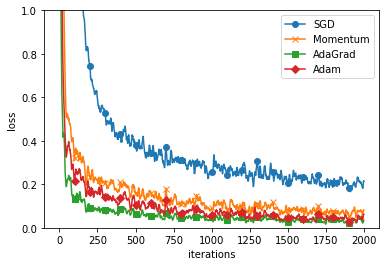

In [13]:
import matplotlib.pyplot as plt
from mnist import load_mnist
from collections import OrderedDict

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)#MNIST데이터셋
train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

optimizers = {}#실험용 설정
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    

for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")#반복
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))
            
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

# 6.2 가중치의 초깃값  
가중치의 초깃값 설정에 따라 신경망 학습의 효율 및 성패가 달라진다.  

## 6.2.1 초깃값을 0으로 하면?  
가중치 감소:오버피팅을 억제해 범용 성능을 높이는 테크닉  
- 가중치 매개변수의 값이 작아지도록 학습하는 방법->오버피팅 방지  

가중치를 작게 하여 오버피팅 방지하려면, 초깃값도 가능한한 작게 해야한다  
만약, 가중치의 초깃값을 모두 0으로 설정하면, 학습이 올바르게 이뤄지지 않음  
- 이유: 오차역전파법에서 모든 가중치의 값이 똑같이 갱신되기 때문이다  
ex)2층 신경망에서 1,2번째 층의 가중치가 0이라면 순전파때는 입력층의 가중치가 0이기 때문에 두번째 층의 뉴런에 모두 같은 값 전달 -> 즉 역전파때 두번째 층의 가중치가 모두 똑같이 갱신되는데 여전히 갱신을 거쳐도 같은 값을 유지->의미없는 행동  

따라서, 초깃값을 무작위로 설정해야한다!

## 6.2.2 은닉층의 활성화값 분포  
은닉층의 활성화값의 분포를 관찰하면 중요한 정보를 얻을 수 있다.  
-가중치의 초깃값에 따라 은닉층의 활성화값들이 어떻게 변화하는지에 대한 간단한 실험(아래)-

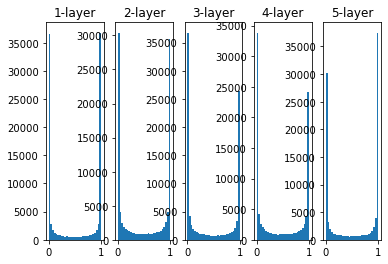

In [14]:
import numpy as np
import matplotlib.pyplot as plt
def sigmoid(x):
    return 1/(1+np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

x=np.random.randn(1000,100)#1000개 데이터
node_num=100#각 은닉층의 노드(뉴런) 수
hidden_layer_size=5#은닉층 5개
activations={}#활성화결과를 저장

def get_activation(hidden_layer_size, x, w, a_func=sigmoid):
    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]
        a = np.dot(x, w)
        z = a_func(a)
        activations[i] = z
    return activations

for i in range(hidden_layer_size):
    if i!=0:
        x=activations[i-1]
    w=np.random.randn(node_num,node_num)*1
    a=np.dot(x,w)
    z=sigmoid(a)
    activations[i]=z

#히스토그램 그리기(가중치 표준편차를 1로 한 경우)
for i,a in activations.items():
    plt.subplot(1,len(activations),i+1)
    plt.title(str(i+1)+"-layer")
    plt.hist(a.flatten(),30,range=(0,1))
plt.show()

기울기 소실(gradient descent)-각 층의 활성화 값들이 0,1에 치우쳐져있다. 데이터가 0,1에 분포하게 되면, 역전파의 기울기값이 점점 작아지다가 사라진다

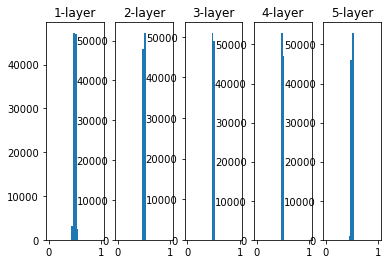

In [15]:
#표준편차를 0.01로 하면 활성화값 분포가 0.5부근에 집중된다. 활성화값들이 치우치면 표현력을 제한하는 문제 발생

for i in range(hidden_layer_size):
    if i!=0:
        x=activations[i-1]
    w=np.random.randn(node_num,node_num)*0.01#가중치 표준편차를 0.01로 한 경우
    a=np.dot(x,w)
    z=sigmoid(a)
    activations[i]=z
for i,a in activations.items():
    plt.subplot(1,len(activations),i+1)
    plt.title(str(i+1)+"-layer")
    plt.hist(a.flatten(),30,range=(0,1))
plt.show()

xavier초깃값: 초깃값의 표준편차가 1/root(n)이 되도록 설정(n은 앞 층의 노드수)  
- xavier초깃값을 사용하면 앞층에 노드가 많을수록 대상노드의 초깃값으로 설정하는 가중치가 좁게 퍼진다.

In [16]:
node_num=100#앞층의 노드수
w=np.random.randn(node_num,node_num)/np.sqrt(node_num)

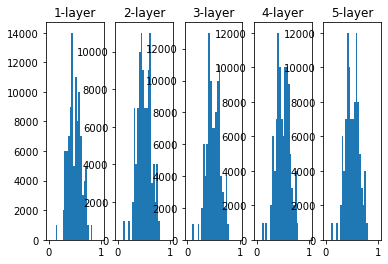

In [17]:
for i in range(hidden_layer_size):
    if i!=0:
        x=activations[i-1]
    a=np.dot(x,w)#xavier초깃값
    z=sigmoid(a)
    activations[i]=z
for i,a in activations.items():
    plt.subplot(1,len(activations),i+1)
    plt.title(str(i+1)+"-layer")
    plt.hist(a.flatten(),30,range=(0,1))
plt.show()

## 6.2.3 ReLU를 사용할 때의 가중치 초깃값  
Xavier초깃값은 활성화함수가 선형인 것을 전제로 이끈 결과  
- cf)sigmoid&tanh함수는 좌우대칭이라 중앙부근이 선형인 함수로 볼 수 있음.But,ReLU를 이용할때는 이에 특화된 초깃값을 이용하는 것을 권장  

He초깃값: ReLU에 특화된 초깃값  
- 앞 계층의 노드가 n개일때, 표준편차가 2 / np.sqrt(n)인 정규분포를 사용  
쓰는 이유 추정:relu함수에서는 음의 영역이 0이라서 더 넓게 분포시키기 위해 2배의 계수가 필요하다고 해석가능  

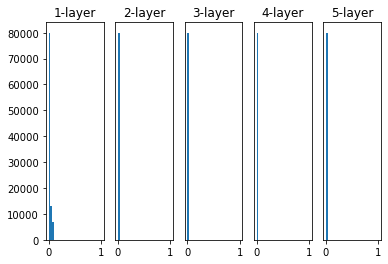

In [18]:
w = np.random.randn(node_num, node_num) * 0.01#표준편차가 0.01인 정규분포를 가중치 초깃값으로 사용한 경우
z = ReLU#relu함수사용
activations = get_activation(hidden_layer_size, x, w, z)
def get_histogram(activations):
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1) + "-layer")
        if i != 0: plt.yticks([], [])
        plt.hist(a.flatten(), 30, range=(0,1))
    plt.show()
get_histogram(activations)

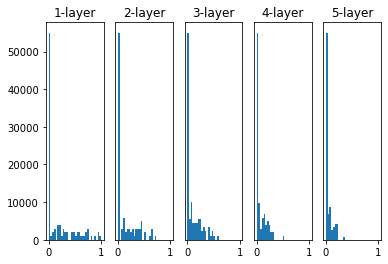

In [19]:
# Xavier 초기값을 사용한 경우
w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
activations = get_activation(hidden_layer_size, x, w, z)
get_histogram(activations)

xavier초깃값 결과를 보면 층이 깊어지면서 치우침이 조금씩 커진다->층이 깊어지면 활성화값들의 치우침도 커지고 학습시, '기울기 소실' 문제 발생  

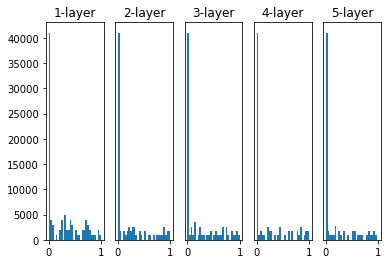

In [20]:
# He 초기값을 사용한 경우->relue에서는 활성화값들이 비교적 균일하게 분포
w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)
activations = get_activation(hidden_layer_size, x, w, z)
get_histogram(activations)

### 정리(활성화함수에 따라)  
- ReLU사용시: He초깃값 사용  
- sigmoid나 tanh사용시: Xavier초깃값 사용  

## 6.2.4 MNIST데이터셋으로 본 가중치 초깃값 비교  

===========iteration:0===========
std=0.01:2.3025350422849327
Xavier:2.3079182587397904
He:2.366113174006687
===========iteration:100===========
std=0.01:2.302614160900574
Xavier:2.2440301804834473
He:1.8996163882628034
===========iteration:200===========
std=0.01:2.303370520433529
Xavier:2.048972027286297
He:0.9205715128953053
===========iteration:300===========
std=0.01:2.301848284563802
Xavier:1.6485466027844242
He:0.6813233972331487
===========iteration:400===========
std=0.01:2.3032913627159806
Xavier:1.0627925324031917
He:0.5732594017137871
===========iteration:500===========
std=0.01:2.300453552600108
Xavier:0.7863998301883175
He:0.5523172696841951
===========iteration:600===========
std=0.01:2.301370363813957
Xavier:0.4988542680006658
He:0.3201168528089097
===========iteration:700===========
std=0.01:2.3023004062605485
Xavier:0.5519541592468417
He:0.3694645184208758
===========iteration:800===========
std=0.01:2.2935589571163284
Xavier:0.3249402741079842
He:0.1728899608036825
=

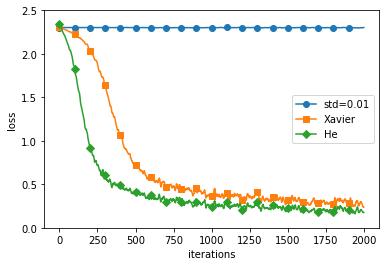

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

# 1. 실험용 설정
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []

# 2. 훈련 시작
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

# 6.3 배치 정규화  

## 6.3.1 배치 정규화 알고리즘  
배치 정규화가 주목받는 이유:
- 1.학습을 빨리 진행할 수 있다(학습 속도개선)  
- 2.초깃값에 크게 의존x  
- 3.오버피팅 억제한다(드롭아웃등 필요성 감소) 

미니배치 B={x1, x2, ..., xm}  
m개의 입력 데이터의 집합에 대해 평균과 분산을 구함.  
그 입력 데이터를 평균이 0, 분산이 1이 되게 (적절한 분포가 되게) 정규화  
배치 정규화 계층마다 정규화된 데이터에 고유한 확대와 이동 변환을 수행한다.  
cf) 입실론 기호는 작은 값(ex.10e-7)으로 0으로 나누는 사태를 예방하는 역할  

## 6.3.2 배치정규화의 효과  
MNIST데이터셋을 사용하여 배치 정규화 계층을 사용o/사용x일때 학습진도의 차이 비교  

거의 모든 경우, 배치정규화를 사용시 학습진도가 빠르다!  
- 배치 정규화를 이용하지 않을때는 초깃값이 잘 분포되어있지 않아 학습이 전혀 진행되지 않는 모습도 확인 가능  

# 6.4 바른 학습을 위해  
오버피팅:신경망이 훈련데이터에만 지나치게 적응되어 그외의 데이터에는 제대로 대응하지 못하는 상태를 의미  
즉, 모델 복잡도가 높아져서 훈련데이터는 잘 맞추지만, 평가 데이터는 잘 못 맞추는 경향을 보이는 문제임  

## 6.4.1 오버피팅  
오버피팅이 일어나는 두가지 경우  
1. 매개변수가 많고 표현력이 높은 모델  
2. 훈련데이터가 적음  

In [22]:
#오버피팅 예시
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]
import numpy as np
import matplotlib.pyplot as plt
weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
#weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

epoch:0, train acc:0.1, test acc:0.1016
epoch:1, train acc:0.12, test acc:0.1039
epoch:2, train acc:0.11333333333333333, test acc:0.1104
epoch:3, train acc:0.12666666666666668, test acc:0.1154
epoch:4, train acc:0.14, test acc:0.1203
epoch:5, train acc:0.15666666666666668, test acc:0.1272
epoch:6, train acc:0.17666666666666667, test acc:0.1372
epoch:7, train acc:0.21333333333333335, test acc:0.1523
epoch:8, train acc:0.25, test acc:0.1728
epoch:9, train acc:0.28, test acc:0.193
epoch:10, train acc:0.31666666666666665, test acc:0.2148
epoch:11, train acc:0.35, test acc:0.2417
epoch:12, train acc:0.37666666666666665, test acc:0.2574
epoch:13, train acc:0.4066666666666667, test acc:0.276
epoch:14, train acc:0.4166666666666667, test acc:0.3056
epoch:15, train acc:0.45, test acc:0.321
epoch:16, train acc:0.4866666666666667, test acc:0.3444
epoch:17, train acc:0.49333333333333335, test acc:0.3682
epoch:18, train acc:0.5133333333333333, test acc:0.3791
epoch:19, train acc:0.5533333333333333, 

epoch:171, train acc:1.0, test acc:0.7726
epoch:172, train acc:1.0, test acc:0.7697
epoch:173, train acc:1.0, test acc:0.7719
epoch:174, train acc:1.0, test acc:0.7718
epoch:175, train acc:1.0, test acc:0.7727
epoch:176, train acc:1.0, test acc:0.7721
epoch:177, train acc:1.0, test acc:0.7729
epoch:178, train acc:1.0, test acc:0.7736
epoch:179, train acc:1.0, test acc:0.773
epoch:180, train acc:1.0, test acc:0.7734
epoch:181, train acc:1.0, test acc:0.7737
epoch:182, train acc:1.0, test acc:0.7748
epoch:183, train acc:1.0, test acc:0.7748
epoch:184, train acc:1.0, test acc:0.7762
epoch:185, train acc:1.0, test acc:0.7777
epoch:186, train acc:1.0, test acc:0.7775
epoch:187, train acc:1.0, test acc:0.7757
epoch:188, train acc:1.0, test acc:0.7739
epoch:189, train acc:1.0, test acc:0.7739
epoch:190, train acc:1.0, test acc:0.772
epoch:191, train acc:1.0, test acc:0.7733
epoch:192, train acc:1.0, test acc:0.7737
epoch:193, train acc:1.0, test acc:0.7752
epoch:194, train acc:1.0, test acc:0

============== 1/16 ==============
epoch:0 | 0.099 - 0.106


C:\Users\a0103\AppData\Local\Temp\ipykernel_21052\804807981.py:43: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size
C:\Users\a0103\AppData\Local\Temp\ipykernel_21052\1259657079.py:95: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
C:\Users\a0103\AppData\Local\Temp\ipykernel_21052\1259657079.py:95: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.097 - 0.085
epoch:2 | 0.097 - 0.091
epoch:3 | 0.097 - 0.116
epoch:4 | 0.097 - 0.142
epoch:5 | 0.097 - 0.161
epoch:6 | 0.097 - 0.178
epoch:7 | 0.097 - 0.2
epoch:8 | 0.097 - 0.217
epoch:9 | 0.097 - 0.237
epoch:10 | 0.097 - 0.254
epoch:11 | 0.097 - 0.275
epoch:12 | 0.097 - 0.295
epoch:13 | 0.097 - 0.324
epoch:14 | 0.097 - 0.335
epoch:15 | 0.097 - 0.359
epoch:16 | 0.097 - 0.374
epoch:17 | 0.097 - 0.392
epoch:18 | 0.097 - 0.405


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.097 - 0.416
============== 2/16 ==============
epoch:0 | 0.099 - 0.106


C:\Users\a0103\AppData\Local\Temp\ipykernel_21052\804807981.py:43: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size
C:\Users\a0103\AppData\Local\Temp\ipykernel_21052\1259657079.py:95: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
C:\Users\a0103\AppData\Local\Temp\ipykernel_21052\1259657079.py:95: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
C:\Users\a0103\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


epoch:1 | 0.097 - 0.088
epoch:2 | 0.097 - 0.09
epoch:3 | 0.097 - 0.124
epoch:4 | 0.097 - 0.144
epoch:5 | 0.097 - 0.167
epoch:6 | 0.097 - 0.199
epoch:7 | 0.097 - 0.214
epoch:8 | 0.097 - 0.244
epoch:9 | 0.097 - 0.289
epoch:10 | 0.097 - 0.306
epoch:11 | 0.097 - 0.316
epoch:12 | 0.097 - 0.341
epoch:13 | 0.097 - 0.362
epoch:14 | 0.097 - 0.394
epoch:15 | 0.097 - 0.419
epoch:16 | 0.097 - 0.422
epoch:17 | 0.097 - 0.441
epoch:18 | 0.097 - 0.465
epoch:19 | 0.097 - 0.474


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 3/16 ==============
epoch:0 | 0.095 - 0.094


C:\Users\a0103\AppData\Local\Temp\ipykernel_21052\804807981.py:43: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size


epoch:1 | 0.251 - 0.103
epoch:2 | 0.434 - 0.154
epoch:3 | 0.517 - 0.196
epoch:4 | 0.594 - 0.239
epoch:5 | 0.663 - 0.276
epoch:6 | 0.707 - 0.312
epoch:7 | 0.744 - 0.355
epoch:8 | 0.783 - 0.384
epoch:9 | 0.798 - 0.411
epoch:10 | 0.836 - 0.442
epoch:11 | 0.859 - 0.477
epoch:12 | 0.879 - 0.508
epoch:13 | 0.891 - 0.522
epoch:14 | 0.905 - 0.553
epoch:15 | 0.925 - 0.583
epoch:16 | 0.929 - 0.59
epoch:17 | 0.941 - 0.61
epoch:18 | 0.951 - 0.628


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.957 - 0.659
============== 4/16 ==============
epoch:0 | 0.126 - 0.122
epoch:1 | 0.253 - 0.147
epoch:2 | 0.341 - 0.253
epoch:3 | 0.456 - 0.342
epoch:4 | 0.539 - 0.409
epoch:5 | 0.597 - 0.482
epoch:6 | 0.64 - 0.527
epoch:7 | 0.66 - 0.562
epoch:8 | 0.688 - 0.595
epoch:9 | 0.727 - 0.617
epoch:10 | 0.744 - 0.636
epoch:11 | 0.757 - 0.66
epoch:12 | 0.775 - 0.687
epoch:13 | 0.781 - 0.697
epoch:14 | 0.807 - 0.724
epoch:15 | 0.814 - 0.744
epoch:16 | 0.823 - 0.764
epoch:17 | 0.824 - 0.771
epoch:18 | 0.849 - 0.784


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.837 - 0.791
============== 5/16 ==============
epoch:0 | 0.103 - 0.092
epoch:1 | 0.109 - 0.13
epoch:2 | 0.109 - 0.314
epoch:3 | 0.112 - 0.428
epoch:4 | 0.115 - 0.537
epoch:5 | 0.121 - 0.612
epoch:6 | 0.123 - 0.667
epoch:7 | 0.126 - 0.697
epoch:8 | 0.136 - 0.725
epoch:9 | 0.151 - 0.755
epoch:10 | 0.174 - 0.777
epoch:11 | 0.182 - 0.791
epoch:12 | 0.197 - 0.805
epoch:13 | 0.22 - 0.824
epoch:14 | 0.238 - 0.835
epoch:15 | 0.229 - 0.846
epoch:16 | 0.252 - 0.858
epoch:17 | 0.255 - 0.87
epoch:18 | 0.247 - 0.882


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.245 - 0.886
============== 6/16 ==============
epoch:0 | 0.111 - 0.097
epoch:1 | 0.117 - 0.205
epoch:2 | 0.117 - 0.456
epoch:3 | 0.119 - 0.581
epoch:4 | 0.117 - 0.655
epoch:5 | 0.17 - 0.711
epoch:6 | 0.117 - 0.752
epoch:7 | 0.125 - 0.771
epoch:8 | 0.172 - 0.799
epoch:9 | 0.148 - 0.829
epoch:10 | 0.148 - 0.858
epoch:11 | 0.149 - 0.87
epoch:12 | 0.166 - 0.888
epoch:13 | 0.173 - 0.892
epoch:14 | 0.132 - 0.909
epoch:15 | 0.139 - 0.923
epoch:16 | 0.164 - 0.931
epoch:17 | 0.174 - 0.941
epoch:18 | 0.168 - 0.953


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.171 - 0.954
============== 7/16 ==============
epoch:0 | 0.105 - 0.092
epoch:1 | 0.117 - 0.235
epoch:2 | 0.117 - 0.588
epoch:3 | 0.116 - 0.695
epoch:4 | 0.117 - 0.756
epoch:5 | 0.117 - 0.795
epoch:6 | 0.117 - 0.835
epoch:7 | 0.117 - 0.854
epoch:8 | 0.117 - 0.88
epoch:9 | 0.117 - 0.898
epoch:10 | 0.117 - 0.92
epoch:11 | 0.116 - 0.94
epoch:12 | 0.116 - 0.952
epoch:13 | 0.116 - 0.963
epoch:14 | 0.116 - 0.97
epoch:15 | 0.116 - 0.979
epoch:16 | 0.116 - 0.986
epoch:17 | 0.116 - 0.991
epoch:18 | 0.116 - 0.991
epoch:19 | 0.116 - 0.992


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 8/16 ==============
epoch:0 | 0.116 - 0.097
epoch:1 | 0.116 - 0.385
epoch:2 | 0.116 - 0.694
epoch:3 | 0.117 - 0.792
epoch:4 | 0.117 - 0.846
epoch:5 | 0.117 - 0.889
epoch:6 | 0.116 - 0.923
epoch:7 | 0.116 - 0.947
epoch:8 | 0.116 - 0.962
epoch:9 | 0.116 - 0.978
epoch:10 | 0.117 - 0.981
epoch:11 | 0.117 - 0.985
epoch:12 | 0.117 - 0.99
epoch:13 | 0.117 - 0.994
epoch:14 | 0.117 - 0.995
epoch:15 | 0.117 - 0.996
epoch:16 | 0.117 - 0.998
epoch:17 | 0.117 - 0.998
epoch:18 | 0.117 - 0.999
epoch:19 | 0.117 - 1.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 9/16 ==============
epoch:0 | 0.117 - 0.103
epoch:1 | 0.116 - 0.449
epoch:2 | 0.117 - 0.66
epoch:3 | 0.117 - 0.735
epoch:4 | 0.116 - 0.827
epoch:5 | 0.117 - 0.865
epoch:6 | 0.117 - 0.879
epoch:7 | 0.117 - 0.891
epoch:8 | 0.117 - 0.901
epoch:9 | 0.117 - 0.915
epoch:10 | 0.117 - 0.919
epoch:11 | 0.117 - 0.98
epoch:12 | 0.117 - 0.992
epoch:13 | 0.117 - 0.995
epoch:14 | 0.117 - 0.997
epoch:15 | 0.116 - 0.998
epoch:16 | 0.116 - 0.998
epoch:17 | 0.116 - 0.998
epoch:18 | 0.116 - 0.997


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 0.998
============== 10/16 ==============
epoch:0 | 0.117 - 0.121
epoch:1 | 0.116 - 0.639
epoch:2 | 0.105 - 0.808
epoch:3 | 0.117 - 0.89
epoch:4 | 0.117 - 0.904
epoch:5 | 0.117 - 0.943
epoch:6 | 0.116 - 0.962
epoch:7 | 0.116 - 0.975
epoch:8 | 0.116 - 0.986
epoch:9 | 0.116 - 0.989
epoch:10 | 0.116 - 0.983
epoch:11 | 0.116 - 0.994
epoch:12 | 0.116 - 0.996
epoch:13 | 0.116 - 0.913
epoch:14 | 0.116 - 0.998
epoch:15 | 0.116 - 0.997
epoch:16 | 0.116 - 0.999
epoch:17 | 0.116 - 0.998
epoch:18 | 0.116 - 0.999


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 0.999
============== 11/16 ==============
epoch:0 | 0.105 - 0.18
epoch:1 | 0.117 - 0.622
epoch:2 | 0.117 - 0.735
epoch:3 | 0.117 - 0.758
epoch:4 | 0.117 - 0.831
epoch:5 | 0.117 - 0.865
epoch:6 | 0.117 - 0.833
epoch:7 | 0.117 - 0.862
epoch:8 | 0.116 - 0.762
epoch:9 | 0.116 - 0.825
epoch:10 | 0.116 - 0.89
epoch:11 | 0.117 - 0.896
epoch:12 | 0.116 - 0.896
epoch:13 | 0.117 - 0.856
epoch:14 | 0.116 - 0.845
epoch:15 | 0.116 - 0.896
epoch:16 | 0.116 - 0.901
epoch:17 | 0.116 - 0.899
epoch:18 | 0.116 - 0.904


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 0.904
============== 12/16 ==============
epoch:0 | 0.116 - 0.142
epoch:1 | 0.117 - 0.5
epoch:2 | 0.117 - 0.575
epoch:3 | 0.117 - 0.594
epoch:4 | 0.117 - 0.609
epoch:5 | 0.117 - 0.611
epoch:6 | 0.117 - 0.655
epoch:7 | 0.117 - 0.716
epoch:8 | 0.117 - 0.783
epoch:9 | 0.116 - 0.759
epoch:10 | 0.117 - 0.767
epoch:11 | 0.117 - 0.781
epoch:12 | 0.117 - 0.822
epoch:13 | 0.117 - 0.879
epoch:14 | 0.117 - 0.886
epoch:15 | 0.117 - 0.889
epoch:16 | 0.117 - 0.885
epoch:17 | 0.117 - 0.893
epoch:18 | 0.117 - 0.884
epoch:19 | 0.117 - 0.909


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 13/16 ==============
epoch:0 | 0.117 - 0.189
epoch:1 | 0.117 - 0.468
epoch:2 | 0.117 - 0.526
epoch:3 | 0.117 - 0.568
epoch:4 | 0.117 - 0.564
epoch:5 | 0.117 - 0.518
epoch:6 | 0.117 - 0.587
epoch:7 | 0.117 - 0.572
epoch:8 | 0.117 - 0.583
epoch:9 | 0.117 - 0.571
epoch:10 | 0.117 - 0.608
epoch:11 | 0.117 - 0.596
epoch:12 | 0.116 - 0.608
epoch:13 | 0.116 - 0.623
epoch:14 | 0.116 - 0.624
epoch:15 | 0.116 - 0.614
epoch:16 | 0.116 - 0.613
epoch:17 | 0.116 - 0.617
epoch:18 | 0.116 - 0.617


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 0.636
============== 14/16 ==============
epoch:0 | 0.117 - 0.191
epoch:1 | 0.117 - 0.428
epoch:2 | 0.117 - 0.547
epoch:3 | 0.116 - 0.655
epoch:4 | 0.116 - 0.661
epoch:5 | 0.116 - 0.67
epoch:6 | 0.116 - 0.699
epoch:7 | 0.116 - 0.702
epoch:8 | 0.117 - 0.703
epoch:9 | 0.117 - 0.702
epoch:10 | 0.117 - 0.693
epoch:11 | 0.117 - 0.698
epoch:12 | 0.117 - 0.716
epoch:13 | 0.117 - 0.713
epoch:14 | 0.117 - 0.716
epoch:15 | 0.117 - 0.716
epoch:16 | 0.116 - 0.722
epoch:17 | 0.117 - 0.472
epoch:18 | 0.117 - 0.71


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.725
============== 15/16 ==============
epoch:0 | 0.105 - 0.143
epoch:1 | 0.117 - 0.228
epoch:2 | 0.117 - 0.401
epoch:3 | 0.099 - 0.444
epoch:4 | 0.117 - 0.476
epoch:5 | 0.117 - 0.476
epoch:6 | 0.117 - 0.5
epoch:7 | 0.117 - 0.507
epoch:8 | 0.117 - 0.517
epoch:9 | 0.117 - 0.52
epoch:10 | 0.117 - 0.401
epoch:11 | 0.117 - 0.491
epoch:12 | 0.117 - 0.51
epoch:13 | 0.117 - 0.518
epoch:14 | 0.117 - 0.52
epoch:15 | 0.117 - 0.521
epoch:16 | 0.117 - 0.521
epoch:17 | 0.117 - 0.522
epoch:18 | 0.117 - 0.524


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.525
============== 16/16 ==============
epoch:0 | 0.116 - 0.153
epoch:1 | 0.105 - 0.294
epoch:2 | 0.116 - 0.378
epoch:3 | 0.116 - 0.406
epoch:4 | 0.116 - 0.413
epoch:5 | 0.116 - 0.409
epoch:6 | 0.117 - 0.417
epoch:7 | 0.116 - 0.401
epoch:8 | 0.116 - 0.385
epoch:9 | 0.116 - 0.403
epoch:10 | 0.116 - 0.432
epoch:11 | 0.116 - 0.424
epoch:12 | 0.116 - 0.434
epoch:13 | 0.116 - 0.435
epoch:14 | 0.116 - 0.436
epoch:15 | 0.116 - 0.339
epoch:16 | 0.116 - 0.435
epoch:17 | 0.116 - 0.449
epoch:18 | 0.117 - 0.454
epoch:19 | 0.116 - 0.407


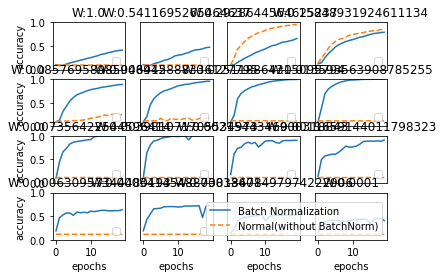

In [25]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from mnist import load_mnist
#from multi_layer_net_extend import MultiLayerNetExtend
#from optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784,
                                     hidden_size_list=[100, 100, 100, 100, 100],
                                     output_size=10,
                                     weight_init_std=weight_init_std,
                                     use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784,
                                  hidden_size_list=[100, 100, 100, 100, 100],
                                  output_size=10,
                                  weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)

    train_acc_list = []
    bn_train_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0

    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)

        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)

            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - "
                  + str(bn_train_acc))

            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break

    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print("============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)

    plt.subplot(4, 4, i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list,
                 label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle="--",
                 label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')

plt.show()

epoch:0, train acc:0.10666666666666667, test acc:0.1032
epoch:1, train acc:0.13, test acc:0.1137
epoch:2, train acc:0.13666666666666666, test acc:0.1262
epoch:3, train acc:0.20333333333333334, test acc:0.1445
epoch:4, train acc:0.22333333333333333, test acc:0.1666
epoch:5, train acc:0.25666666666666665, test acc:0.1887
epoch:6, train acc:0.2733333333333333, test acc:0.208
epoch:7, train acc:0.2866666666666667, test acc:0.2266
epoch:8, train acc:0.31, test acc:0.2388
epoch:9, train acc:0.33666666666666667, test acc:0.2478
epoch:10, train acc:0.33666666666666667, test acc:0.2585
epoch:11, train acc:0.36333333333333334, test acc:0.268
epoch:12, train acc:0.3566666666666667, test acc:0.271
epoch:13, train acc:0.36, test acc:0.2759
epoch:14, train acc:0.36333333333333334, test acc:0.2861
epoch:15, train acc:0.38, test acc:0.2954
epoch:16, train acc:0.3933333333333333, test acc:0.305
epoch:17, train acc:0.4033333333333333, test acc:0.3073
epoch:18, train acc:0.43333333333333335, test acc:0.3

epoch:165, train acc:1.0, test acc:0.7172
epoch:166, train acc:1.0, test acc:0.7174
epoch:167, train acc:1.0, test acc:0.7175
epoch:168, train acc:1.0, test acc:0.7158
epoch:169, train acc:1.0, test acc:0.716
epoch:170, train acc:1.0, test acc:0.717
epoch:171, train acc:1.0, test acc:0.7169
epoch:172, train acc:1.0, test acc:0.7194
epoch:173, train acc:1.0, test acc:0.7178
epoch:174, train acc:1.0, test acc:0.7187
epoch:175, train acc:1.0, test acc:0.718
epoch:176, train acc:1.0, test acc:0.7163
epoch:177, train acc:1.0, test acc:0.718
epoch:178, train acc:1.0, test acc:0.719
epoch:179, train acc:1.0, test acc:0.7206
epoch:180, train acc:1.0, test acc:0.719
epoch:181, train acc:1.0, test acc:0.7189
epoch:182, train acc:1.0, test acc:0.7223
epoch:183, train acc:1.0, test acc:0.7211
epoch:184, train acc:1.0, test acc:0.7206
epoch:185, train acc:1.0, test acc:0.7208
epoch:186, train acc:1.0, test acc:0.7199
epoch:187, train acc:1.0, test acc:0.7211
epoch:188, train acc:1.0, test acc:0.720

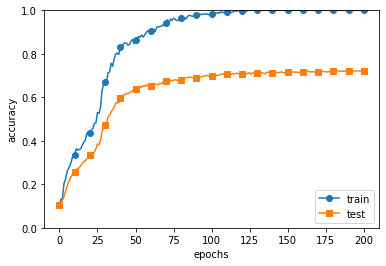

In [27]:
(x_train,t_train),(x_test,t_test)=load_mnist(normalize=True)
x_train=x_train[:300]
t_train=t_train[:300]
network=MultiLayerNet(input_size=784,hidden_size_list=[100,100,100,100,100,100],output_size=10)
optimizer=SGD(lr=0.01)
max_epochs=201
train_size=x_train.shape[0]
batch_size=100
train_loss_list=[]
train_acc_list=[]
test_acc_list=[]
iter_per_epoch=max(train_size/batch_size,1)
epoch_cnt=0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc)
              + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 6.4.2 가중치 감소  
가중치 감소:오버피팅 억제용으로 많이 이용. 학습과정에서 큰 가중치에 대해서는 그에 상응하는 큰 페널티를 부과하여 오버피팅을 억제하는 방법  
- overfitting은 가중치 매개변수값이 커서 발생하는 경우가 많음  

신경망 학습의 목적!-손실함수 값 줄이기  
ex) 가중치 제곱노름(L2노름)을 손실함수에 더한다->가중치가 커지는 것을 억제  
가중치가 W면, L2노름에 따른 가중치 감소는 1/2lambdaW**2이 되고,이를 손실함수에 더함(lambda는 정규화의 세기 조절하는 하이퍼파라미터)  
lambda를 크게 설정할수록 큰 가중치에 대한 페널티가 커진다.  

### 가중치 감소는 모든 가중치 각각의 손실함수에 1/2lambda*W**2를 더함  
따라서 가중치의 기울기를 구하는 계산에서는 오차역전파법에 따른 결과에 정규화항을 미분한 lambda W를 더한다  

epoch:0, train acc:0.15, test acc:0.1408
epoch:1, train acc:0.17666666666666667, test acc:0.1512
epoch:2, train acc:0.19333333333333333, test acc:0.1649
epoch:3, train acc:0.20333333333333334, test acc:0.174
epoch:4, train acc:0.21333333333333335, test acc:0.1788
epoch:5, train acc:0.23666666666666666, test acc:0.1872
epoch:6, train acc:0.23666666666666666, test acc:0.1902
epoch:7, train acc:0.25666666666666665, test acc:0.2003
epoch:8, train acc:0.26, test acc:0.2049
epoch:9, train acc:0.31, test acc:0.2191
epoch:10, train acc:0.32, test acc:0.2272
epoch:11, train acc:0.36, test acc:0.2458
epoch:12, train acc:0.37333333333333335, test acc:0.2604
epoch:13, train acc:0.3933333333333333, test acc:0.2843
epoch:14, train acc:0.4266666666666667, test acc:0.2953
epoch:15, train acc:0.43, test acc:0.299
epoch:16, train acc:0.44666666666666666, test acc:0.3153
epoch:17, train acc:0.5066666666666667, test acc:0.3506
epoch:18, train acc:0.5166666666666667, test acc:0.3711
epoch:19, train acc:0.5

epoch:157, train acc:0.9033333333333333, test acc:0.7422
epoch:158, train acc:0.9133333333333333, test acc:0.7433
epoch:159, train acc:0.8866666666666667, test acc:0.7425
epoch:160, train acc:0.88, test acc:0.7368
epoch:161, train acc:0.8933333333333333, test acc:0.7405
epoch:162, train acc:0.8833333333333333, test acc:0.7387
epoch:163, train acc:0.88, test acc:0.7321
epoch:164, train acc:0.8833333333333333, test acc:0.7359
epoch:165, train acc:0.8966666666666666, test acc:0.7355
epoch:166, train acc:0.9166666666666666, test acc:0.7428
epoch:167, train acc:0.8966666666666666, test acc:0.7451
epoch:168, train acc:0.8966666666666666, test acc:0.743
epoch:169, train acc:0.88, test acc:0.7399
epoch:170, train acc:0.8966666666666666, test acc:0.7369
epoch:171, train acc:0.91, test acc:0.7381
epoch:172, train acc:0.8933333333333333, test acc:0.7402
epoch:173, train acc:0.9, test acc:0.7412
epoch:174, train acc:0.8966666666666666, test acc:0.7384
epoch:175, train acc:0.8866666666666667, test 

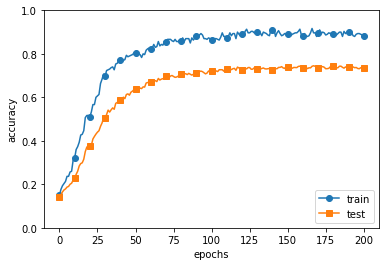

In [28]:
weight_decay_lambda = 0.1#가중치 감소 설정
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break
            
# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 6.4.3 드롭아웃  
- 오버피팅을 억제하는 방식으로 손실함수에 가중치 L2노름을 더한 가중치 감소방법있음  
DropOut: 뉴런을 임의로 삭제하면서 학습하는 방법(더 정교)
1. 훈련때 은닉층의 뉴런을 무작위로 골라 삭제  
2. 삭제된 뉴런은 신호를 전달하지 않게 됨  
3. 훈련때는 데이터를 흘릴때마다 삭제할 뉴런을 무작위로 선택, 시험때는 모든 뉴런에 신호 전달  
cf) 시험때는 각 뉴런의 훈련때 삭제안한 비율을 곱하여 출력  

In [29]:
class Dropout:
    def __init__(self,dropout_ration=0.5):
        self.dropout_ratio=dropout_ratio
        self.mask=None
    
    def forward(self,x,train_flag=True):
        if train_flag:
            self.mask=np.random.randn(*x.shape)>self.dropout_ratio
            return x*self.mask
        else:
            return x*(1.0-self.dropout_ratio)#순전파때 통과시키지 않은 뉴런은 역전파때도 신호차단!
    def backward(self,dout):
        return dout*self.mask
    
#훈련시에는 순전파forward때마다 self.mask에 삭제할 뉴런을 false로 표시함
#역전파때는 순전파때 신호를 통과시키는 뉴런은 역전파때도 신호를 그대로 통과시키고, 
#순전파때 통과시키지 않은 뉴런은 역전파때도 신호 차단  

결론: dropout을 통해서 표현력은 좋고 오버피팅 억제하는 것이 가능하다!  

## 6.5 적절한 하이퍼파라미터 값 찾기  
하이퍼파라미터: 모델에서 인간이 정해야 하는 변수들. 예를 들어, 각층의 뉴런 수, 배치 크기, 매개변수 갱신시의 학습률과 가중치 감소 등이 있음  
- 하이퍼파라미터값을 적절히 설정하지 않으면 모델성능이 떨어질 수도 있음

## 6.5.1 검증 데이터  
성능평가할때 하이퍼파라미터가 대상일때는 시험데이터를 사용해서 하이퍼파라미터를 조정하면 안된다(오버피팅 이슈때문에)  
if. 하이어파라미터값의 "좋음"을 시험데이터로 확인하게 되어 시험데이터에만 맞도록 조정되어 버림->범용성능이 떨어짐  

검증데이터(validation data):하이퍼 파라미터 조정할때는 전용 확인 데이터가 필요(적절성을 평가하는 데이터셋)  

- 훈련데이터:매개변수 학습  
- 검증데이터:하이퍼파라미터 성능 평가  
- 시험데이터:신경망의 범용 성능 평가  

In [30]:
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist()

#훈련 데이터를 셔플
x_train, t_train = shuffle_dataset(x_train, t_train)

#훈련데이터의 20%를 검증 데이터로 분리
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

## 6.5.2 하이퍼 파라미터 최적화  
하이퍼파라미터의 '최적 값'이 존재하는 범위를 조금씩 줄여가는 것  
범위를 조금씩 줄이려면 대략적인 범위를 설정하고 그 범위에서 무작위로 하이퍼파라미터 값을 골라낸뒤, 그 값으로 정확도 평가 

이때, 무작위로 샘플링해 탐색하는 것이 좋은 결과. 최정 정확도에 미치는 영향력이 하이퍼파라미터마다 다르기 때문이다  

cf) '10의 계승'단위로 범위를 지정. 로그 스케일(log scale)로 지정  
0단계: 하이퍼파라미터값의 범위 설정  
1단계: 설정된 범위에서 하이퍼파라미터값을 무작위로 추출  
2단계: 1단계에서 샘플링한 하이퍼파라미터 값을 사용하여 학습하고, 정확도를 평가. (에폭은 작게 설정)  
3단계: 1단계와 2단계를 특정 횟수(100회 등) 반복하며, 그 정확도의 결과를 보고 하이퍼파라미터의 범위를 좁힘  

## 6.5.3 하이퍼파라미터 최적화 구현하기  
MNIST데이터셋을 사용하여 하이퍼파라미터를 최적화하기  
- 학습률과 가중치감소의 세기조절계수를 탐색한다  


적절한 값으로 범위를 좁혀가면서 특정단계에서 최종 하이퍼파리미터값을 하나 선택  